Проект: вариант 4

Задание 1

    Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий 
    в формате Stories (например, для дальнейшего экспорта в Instagram Stories). 
    Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов,
    контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, 
    нужно ли выкатывать новую модель на остальных пользователей.

    В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. 
    Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

Данные:

    active_users – информация о пользователях, которые посещали приложение во время эксперимента. 

    groups – разбивка пользователей на контрольную (А) и тестовую (В) группы. 

    purchases – данные о транзакциях (оплатах) пользователей приложения во время эксперимента 

 

Задание 2

    Одной из основных задач аналитика является не только построение моделей, но и создание дашбордов, которые позволяют 
    отслеживать изменения метрик и принимать на их основе оптимальные решения. 
    Ваш руководитель хочет узнать, 
    как обстоят дела с использованием приложения и вовлечённостью пользователей, и очень просит спроектировать ему дашборд.
    

In [91]:
import pandas as pd
import numpy as np
from math import sqrt
import seaborn as sns
import sys
import plotly.express as px
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from statistics import mean
from scipy.stats import norm, mode, chi2_contingency

In [92]:
# Посмотрим на данные 
active_users_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-petrov/Final_Progect/Проект_4_active_users.csv', sep=',')
groups_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-petrov/Final_Progect/Проект_4_groups.csv', sep=',')
purchases_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-petrov/Final_Progect/Проект_4_purchases.csv', sep=',')




In [93]:
active_users_df.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [94]:
active_users_df.duplicated('country')

0       False
1       False
2        True
3        True
4        True
        ...  
8336     True
8337     True
8338     True
8339     True
8340     True
Length: 8341, dtype: bool

In [95]:
groups_df.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [96]:
purchases_df.head()

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


In [97]:
# Посмотрим на типы данных, проверим на пропуски и уникальные значения

In [98]:
active_users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   8341 non-null   int64 
 1   country   8341 non-null   object
 2   platform  8341 non-null   object
 3   sex       8341 non-null   object
dtypes: int64(1), object(3)
memory usage: 260.8+ KB


In [99]:
# давайте теперь проверьте сумму нулевых значений или отсутствующих значений, используя код ниже:
active_users_df.isnull().sum()

user_id     0
country     0
platform    0
sex         0
dtype: int64

In [100]:
active_users_df.nunique()

user_id     8341
country        2
platform       2
sex            2
dtype: int64

In [101]:
groups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  74576 non-null  int64 
 1   group    74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [102]:
# давайте теперь проверьте сумму нулевых значений или отсутствующих значений, используя код ниже:
groups_df.isna().sum()

user_id    0
group      0
dtype: int64

In [103]:
groups_df.nunique()

user_id    74576
group          2
dtype: int64

In [104]:
purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  541 non-null    int64  
 1   revenue  541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [105]:
purchases_df.isna().sum()

user_id    0
revenue    0
dtype: int64

In [106]:
purchases_df.nunique()

user_id    541
revenue     98
dtype: int64

In [107]:
# По трем таблицам пропусков в данных нет. Есть данные по пользователям из двух стран - Швеция и Россия, мужчины и женщины, 
# использующие одну из двух платформ (ios, android) c разбивкой пользователей на контрольную (А) и тестовую (В) группы.

In [108]:
# Соединение по user_id все данные  в один датафрейм

In [109]:
df = active_users_df.merge(purchases_df, how='left', on='user_id')
df.revenue.fillna(0, inplace=True) #заменяем nan на 0
df.revenue = df['revenue'].astype(int) # преобразуем в целое число
df = df.merge(groups_df, on='user_id')
df_dash=df
df_dash['go_users'] = df_dash.revenue.apply(lambda x: 1 if x > 0 else 0) #те юзеры, которые заходили в приложение в период проведения эксперимента
df_dash.to_csv('dashboard.csv') # Для дашборда
df

,user_id,country,platform,sex,revenue,group,go_users
0,8029,Russia,ios,male,0,B,0
1,1735,Sweden,ios,male,0,B,0
2,7697,Russia,android,male,0,B,0
3,1421,Sweden,android,female,0,B,0
4,1704,Russia,ios,male,0,B,0
...,...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,0,B,0
8337,3755,Russia,ios,male,590,A,1
8338,4594,Sweden,android,female,0,B,0
8339,7430,Sweden,ios,female,0,B,0


 Посмотрим на типы данных

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   8341 non-null   int64 
 1   country   8341 non-null   object
 2   platform  8341 non-null   object
 3   sex       8341 non-null   object
 4   revenue   8341 non-null   int64 
 5   group     8341 non-null   object
 6   go_users  8341 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 521.3+ KB


In [111]:
print('df data types are:' + '\n', df.dtypes)

df data types are:
 user_id      int64
country     object
platform    object
sex         object
revenue      int64
group       object
go_users     int64
dtype: object


In [112]:
numeric_col = ['user_id', 'revenue' ]

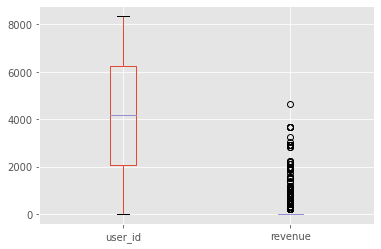

In [113]:
df.boxplot(numeric_col)

In [114]:
# Как видно выше, revenue содержит выбросы, которые лежат над нижней границей

In [115]:
df.describe()

,user_id,revenue,go_users
count,8341.000000,8341.000000,8341.000000
mean,4170.000000,56.553291,0.046997
std,2407.983631,311.346849,0.211645
min,0.000000,0.000000,0.000000
25%,2085.000000,0.000000,0.000000
50%,4170.000000,0.000000,0.000000
75%,6255.000000,0.000000,0.000000
max,8340.000000,4660.000000,1.000000


In [116]:
# Количество пользователей по прибыли

In [117]:
df.groupby('revenue').agg({'user_id' : 'count'})

,user_id
revenue,
0,7949
207,1
208,13
209,11
210,5
...,...
3270,1
3669,1
3670,2


In [118]:
df.revenue.value_counts()

0       7949
1910      48
1909      33
1911      26
300       22
        ... 
890        1
2899       1
4660       1
702        1
1991       1
Name: revenue, Length: 94, dtype: int64

In [120]:
# Активные полььзователи
df.groupby(['group'], as_index=False).agg({'user_id': 'count'}) 

,group,user_id
0,A,1538
1,B,6803


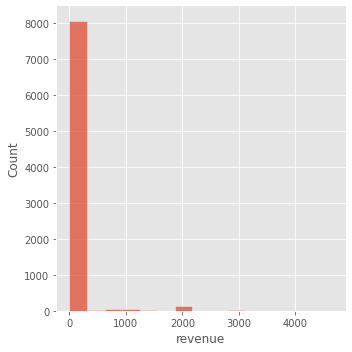

In [121]:
sns.displot(df.revenue, kde=False)

In [122]:
# Видно, что большее число значений  равно 0. Соответственно, важно увидеть закономерности при revenue > 0 

In [31]:
df.query('revenue > 0').groupby('revenue').agg({'user_id' : 'count'}).sort_values(by='revenue')

,user_id
revenue,
207,1
208,13
209,11
210,5
211,2
...,...
3270,1
3669,1
3670,2


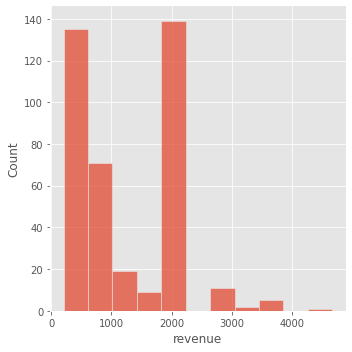

In [32]:
sns.displot(df[df.revenue > 0].revenue, kde=False)

In [33]:
# Теперь проверим,  разницу для контрольной и тестовой группы.

In [34]:
# контрольная (А) группа.
df.query('revenue > 0 and group == "A"').groupby('revenue').agg({'user_id' : 'count'})

,user_id
revenue,
208,5
298,4
299,3
300,9
301,7
302,2
410,1
498,1
499,1


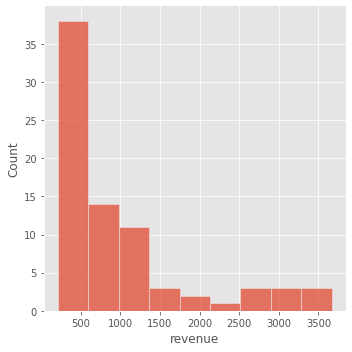

In [35]:
sns.displot(df[(df.group == 'A') & (df.revenue > 0)].revenue, kde=False)

In [36]:
# тестовая (В) группа.
df.query('revenue > 0 and group == "B"').groupby('revenue').agg({'user_id' : 'count'})

,user_id
revenue,
207,1
208,8
209,11
210,5
211,2
...,...
3050,1
3270,1
3670,1


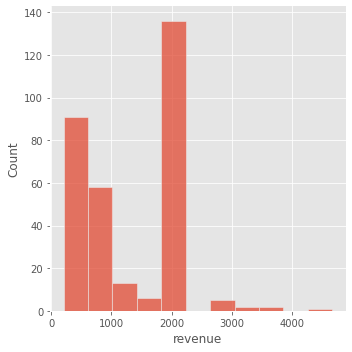

In [37]:
sns.displot(df[(df.group == 'B') & (df.revenue > 0)].revenue, kde=False)

In [38]:
# Вижу, что в тестовой группе(B) и пользователей больше и потратили больше всего
# Делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

# Есть две категориальные переменные → нужен хи-квадрат
# Узнаем- отсутствие взаимосвязи между пользователями, которые совершили оплату, и группой эксперимента (𝐻0 нулевая гипотеза)


𝐻0 : взаимосвязи между переменными нет
𝐻1 : взаимосвязь есть

In [39]:
# применим лямбду-функцию
df['Оплачено'] = df.revenue.apply(lambda x: 'Оплачено' if x > 0 else 'Не_Оплачено')

In [40]:
pd.crosstab(df.Оплачено, df.group)

group,A,B
Оплачено,,
Не_Оплачено,1460,6489
Оплачено,78,314


In [41]:
# Проверка независимости переменных в таблице непредвиденных обстоятельств методом хи-квадрат
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.Оплачено, df.group))

In [42]:
stat, p

(0.48480826522557896, 0.48625240457231045)

Интерпретируем результат:

In [43]:
"""prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')"""

"prob = 0.95\ncritical = chi2.ppf(prob, dof)\nif abs(stat) >= critical:\n    print('Отклоняем H0')\nelse:\n    print('Не отклоняем H0')"

In [44]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


 Значение 'p' намного превышает 0.05, следовательно, не могу отбросить нулевую гипотезу об отсутствии взаимосвязи между переменными ; говорит о том, что конверсия не изменилась при введении  новой модели оплаты.
 Следует проверить, взаимосвязь от платформы, страны или пола

In [45]:
pd.crosstab(df.Оплачено, df.platform)

platform,android,ios
Оплачено,,
Не_Оплачено,4413,3536
Оплачено,208,184


In [46]:
# Проверка независимости переменных в таблице непредвиденных обстоятельств методом хи-квадрат
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.Оплачено, df.platform))

In [47]:
stat, p

(0.8147410687624215, 0.3667222543587335)

Интерпретируем результат:

In [48]:
"""prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')"""

"prob = 0.95\ncritical = chi2.ppf(prob, dof)\nif abs(stat) >= critical:\n    print('Отклоняем H0')\nelse:\n    print('Не отклоняем H0')"

In [49]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [50]:
pd.crosstab(df.Оплачено, df.country)

country,Russia,Sweden
Оплачено,,
Не_Оплачено,5167,2782
Оплачено,240,152


In [51]:
# Проверка независимости переменных в таблице непредвиденных обстоятельств методом хи-квадрат
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.Оплачено, df.country))

In [52]:
stat, p

(2.174959282925695, 0.14027322855215643)

Интерпретируем результат:

In [53]:
"""prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')"""

"prob = 0.95\ncritical = chi2.ppf(prob, dof)\nif abs(stat) >= critical:\n    print('Отклоняем H0')\nelse:\n    print('Не отклоняем H0')"

In [54]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [55]:
pd.crosstab(df.Оплачено, df.sex)

sex,female,male
Оплачено,,
Не_Оплачено,3954,3995
Оплачено,191,201


In [56]:
# Проверка независимости переменных в таблице непредвиденных обстоятельств методом хи-квадрат
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.Оплачено, df.sex))
stat, p

(0.11671860937081469, 0.7326210380083343)

Интерпретируем результат:

In [57]:
"""prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')"""

"prob = 0.95\ncritical = chi2.ppf(prob, dof)\nif abs(stat) >= critical:\n    print('Отклоняем H0')\nelse:\n    print('Не отклоняем H0')"

In [58]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Нулевая гипотеза НЕ ОТКЛОНЯЕТСЯ, поскольку p-value > 0. 05. 
Значит, ВЗАИМОСВЯЗИ НЕТ. На основании данных иследований  "p" : по платформе, стране и полу себя не оправдали. На этом этапе однозначный вывод сделать не могу.

 Рассмотрим  продуктовые метрики для контрольной и тестовой группы:
 CR (конверсия) - отношение числа пользователей, которые принесли доход к общему числу пользователей;
 ARPPU (средний доход на платящего пользователя) - высчитывается как отношение общего дохода на количество заплативших пользователей;
 ARPU (средний доход с привлеченного пользователя) - произведение конверсии и среднего дохода на платящего пользователя.

In [59]:
CR_control = df[(df.revenue > 0) & (df.group == 'A')].shape[0] / df[df.group == 'A'].shape[0]
CR_control

0.05071521456436931

In [60]:
CR_test = df[(df.revenue > 0) & (df.group == 'B')].shape[0] / df[df.group == 'B'].shape[0]
CR_test

0.046156107599588415

In [61]:
if CR_control > CR_test:
    print("CR уменьшился на {0:.2f}%".format((CR_control / CR_test - 1) * 100))
elif CR_control < CR_test:
    print("CR увеличился на {0:.2f}%".format((CR_test / CR_control - 1) * 100))
else:
    print("CR не изменился")

CR уменьшился на 9.88%


In [62]:
# конверсия в тестовой группе стала меньше на 9.88%

In [63]:
# для контрольной (А) группы
ARPPU_control = df[df.group == 'A'].revenue.sum() / df[(df.revenue > 0) & (df.group == 'A')].shape[0]
ARPPU_control

943.5641025641025

In [64]:
# для тестовой (В) группы
ARPPU_test = df[df.group == 'B'].revenue.sum() / df[(df.revenue > 0) & (df.group == 'B')].shape[0]
ARPPU_test

1267.875796178344

In [65]:
if ARPPU_control > ARPPU_test:
    print("ARPPU уменьшился на {0:.2f}%".format((ARPPU_control / ARPPU_test - 1) * 100))
elif ARPPU_control < ARPPU_test:
    print("ARPPU увеличился на {0:.2f}%".format((ARPPU_test / ARPPU_control - 1) * 100))
else:
    print("ARPPU не изменился")

ARPPU увеличился на 34.37%


In [66]:
ARPU_control = CR_control * ARPPU_control
ARPU_control

47.85305591677503

In [67]:
ARPU_test = CR_test * ARPPU_test
ARPU_test

58.520211671321476

In [68]:
if ARPU_control > ARPU_test:
    print("ARPU уменьшился на {0:.2f}%".format((ARPU_control / ARPU_test - 1) * 100))
elif ARPU_control < ARPU_test:
    print("ARPU увеличился на {0:.2f}%".format((ARPU_test / ARPU_control - 1) * 100))
else:
    print("ARPU не изменился")

ARPU увеличился на 22.29%


По результатам исследования мы видим значимое увеличение средниего дохода с привлеченного пользователя и среднего дохода на платящего пользователя в тестовой группе. Видимо, в новой системе есть что-то такое, что побуждает платящих пользователей покупать более дорогие опции или больше товаров. Даже не смотря на то, что конверсия значимо уменьшилась , можно говорить об увеличении прибыли.

Для того, чтобы понять являются ли статистически значимыми изменения в новую модели оплаты коллекций шаблонов  использую метод bootstrap(потому что в выборках имеющихся данных присутствуют повторяющиеся значения).

H0 (нулевая гипотеза): Различий в доходах между двумя группами нет.

H1 (альтернативная гипотеза): Есть различия в доходах между двумя группами

In [69]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    
       
    return p_value

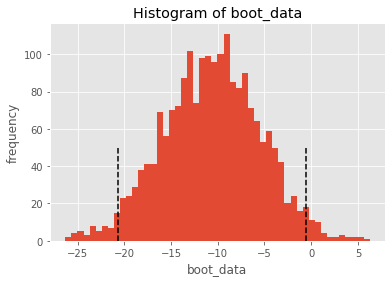

0.039666710449653315


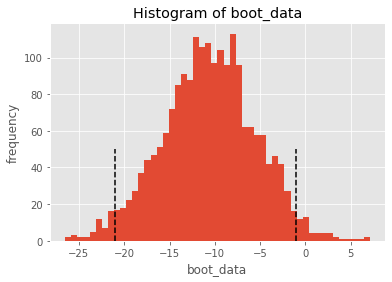

0.03828134146931961


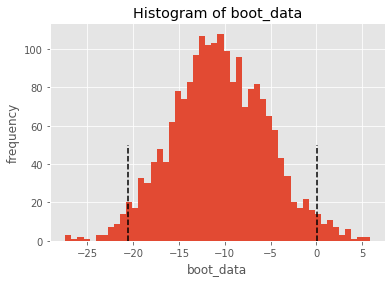

0.04175647470379736


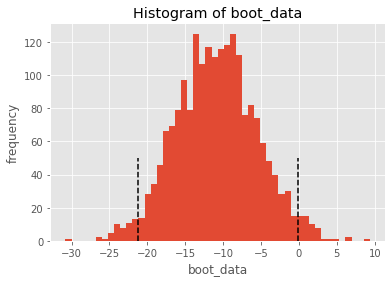

0.04017802744799728


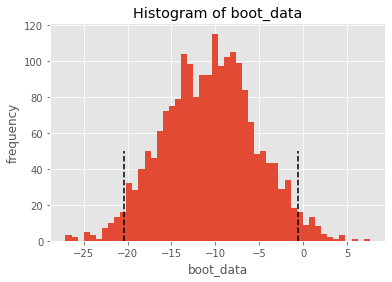

0.041705438440732816


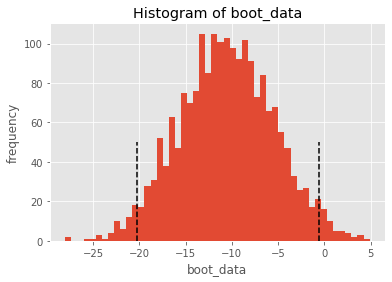

0.03717854071157468


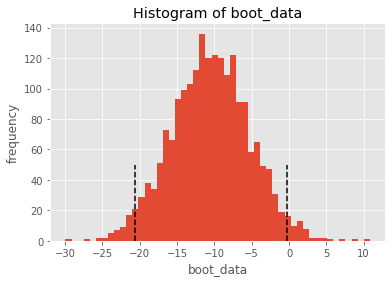

0.044191095279528886


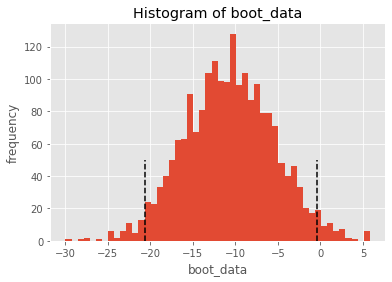

0.04156516249534581


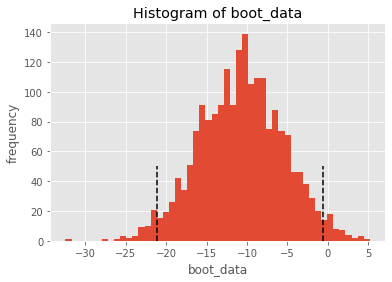

0.038940462976898384


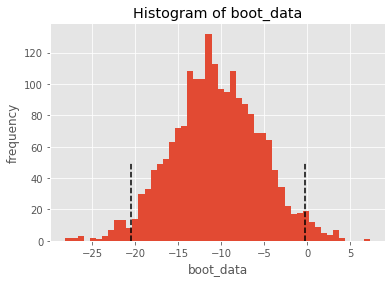

0.03924427996926185
mean = 0.040270753394410996
p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами


In [70]:
df1 = []
for i in range(10):
    it = get_bootstrap(df[df.group == 'A'].revenue, df[df.group == 'B'].revenue)
    df1.append(it)
    print(it)
print(f'mean = {mean(df1)}')
if mean(df1) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

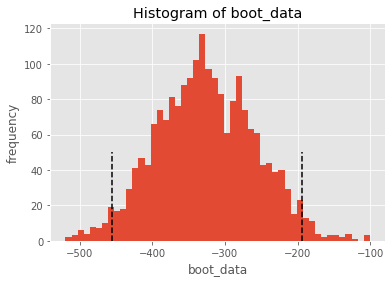

1.5480260264976977e-06


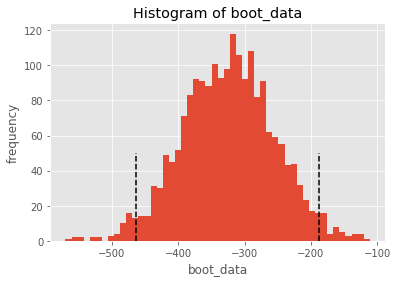

2.6021593939245926e-06


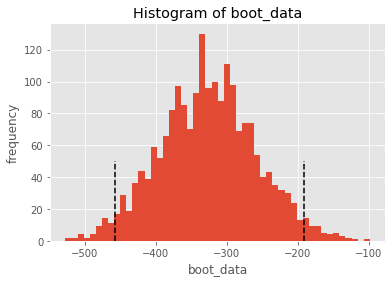

1.3192285376473478e-06


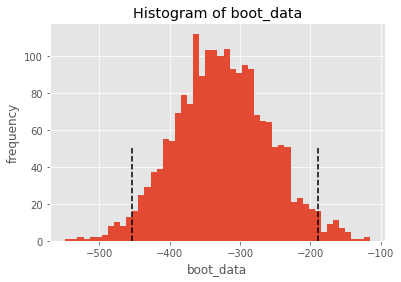

1.0920105235354125e-06


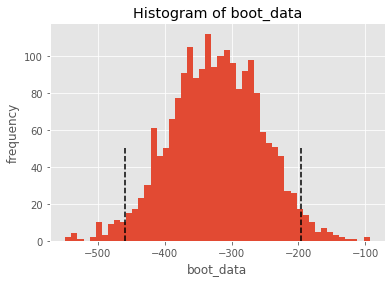

2.137726908408803e-06


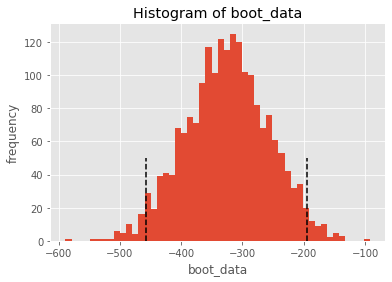

1.7469248816049563e-06


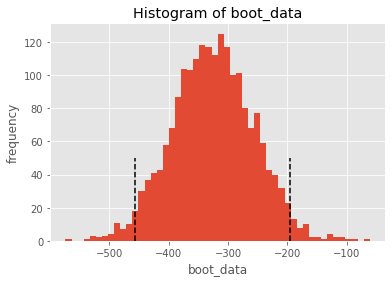

1.887731643601972e-06


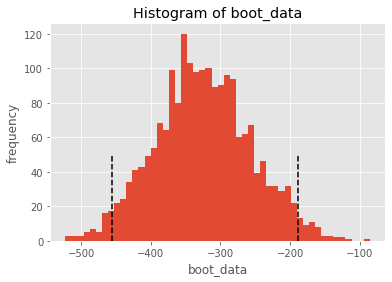

2.337362016926319e-06


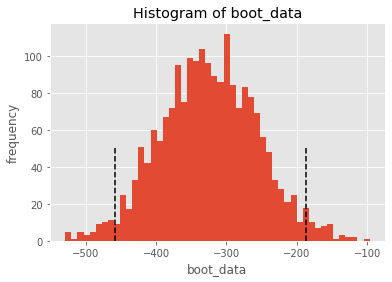

2.2309529357918076e-06


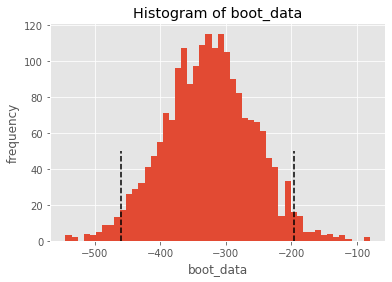

1.7653216743501962e-06
mean = 1.8667444542289106e-06
p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами


In [71]:
# И для revenue > 0

df1 = []
for i in range(10):
    it = get_bootstrap(df[(df.group == 'A') & (df.revenue > 0)].revenue,
                       df[(df.group == 'B') & (df.revenue > 0)].revenue)
    df1.append(it)
    print(it)
print(f'mean = {mean(df1)}')
if mean(df1) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

При анализе с ненулевыми значениями "revenue > 0" p-value меньше 0.05, но и при нулевых значениях  p-value меньше 0.05, поэтому можно с уверенностью отклонить нулевую гипотезу и принять альтернативную, что различия в доходах контрольной и тестовой группы статистически значимы.

На основании этого, можно выкатывать новую модель на остальных пользователей.

Хотелось бы еще проверить  отдельные подкатегории пользователей.

С помощью метода bootstrap можно найти значение p-value для показателей дохода от  подкатегории пользователей

In [72]:
# количество пользователей в каждой подкатегории
df[df.revenue > 0].groupby(df['country'] + '_' + df['platform'] + '_' + df['sex'] + '_' + df['group']).agg({'revenue': 'count'}).sort_values(by='revenue')

,revenue
Sweden_android_female_A,6
Sweden_ios_female_A,7
Russia_android_male_A,8
Sweden_ios_male_A,8
Russia_android_female_A,11
Russia_ios_male_A,11
Russia_ios_female_A,13
Sweden_android_male_A,14
Sweden_ios_male_B,24
Sweden_ios_female_B,27


In [73]:
# мода в каждой подкатегории с заплатившими пользователями
df[df.revenue > 0].groupby(df['country'] + '_' + df['platform'] + '_' + df['sex'] + '_' + df['group'])\
                  .agg(lambda x: mode(x)[0])[['revenue']].sort_values(by='revenue')

,revenue
Russia_android_male_A,208
Sweden_ios_female_A,208
Russia_android_female_A,298
Russia_ios_female_A,300
Russia_ios_male_A,300
Sweden_android_male_A,300
Sweden_android_female_A,301
Sweden_ios_male_A,301
Russia_android_male_B,1909
Sweden_android_male_B,1909


In [74]:
# среднее значение доходов подкатегорий на пользователя
df.groupby(df['country'] + '_' + df['platform'] + '_' + df['sex'] + '_' + df['group'])\
  .agg({'revenue': 'mean'}).sort_values(by='revenue')

,revenue
Russia_android_male_A,18.032922
Sweden_android_female_A,25.586420
Russia_android_female_A,34.756554
Sweden_ios_male_A,35.442953
Russia_ios_male_A,43.883117
Sweden_ios_female_A,44.493333
Russia_ios_male_B,48.357642
Russia_android_male_B,51.374606
Russia_android_female_B,54.762810
Sweden_android_female_B,57.290030


In [75]:
# среднее значение доходов подкатегорий на заплатившего пользователя 
df[df.revenue > 0].groupby(df['country'] + '_' + df['platform'] + '_' + df['sex'] + '_' + df['group'])\
                  .agg({'revenue': 'mean'}).sort_values(by='revenue')

,revenue
Russia_android_male_A,547.750000
Sweden_ios_male_A,660.125000
Sweden_android_female_A,690.833333
Russia_android_female_A,843.636364
Russia_ios_female_A,892.923077
Russia_ios_male_A,921.545455
Sweden_ios_female_A,953.428571
Russia_ios_male_B,987.877551
Sweden_android_female_B,1149.272727
Sweden_android_male_B,1180.303030


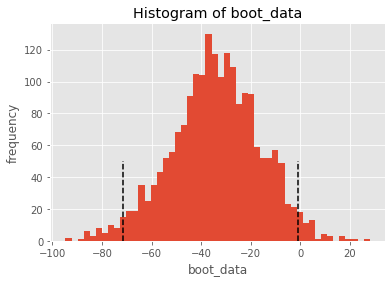

0.05552821933757879


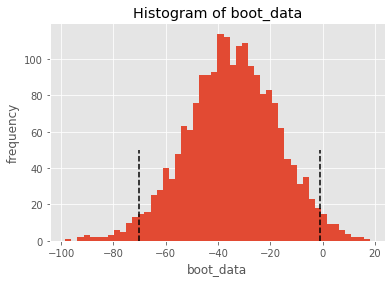

0.04800976352267483


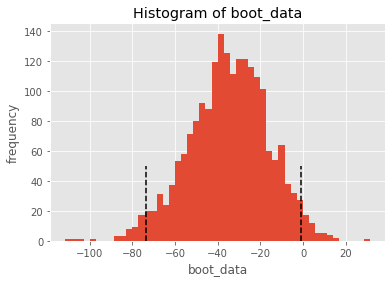

0.058598060619056015


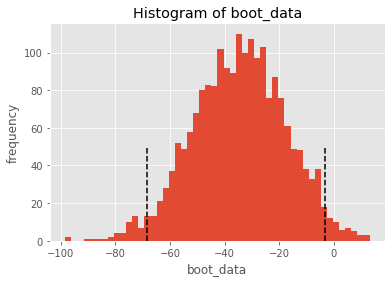

0.04087255226351227


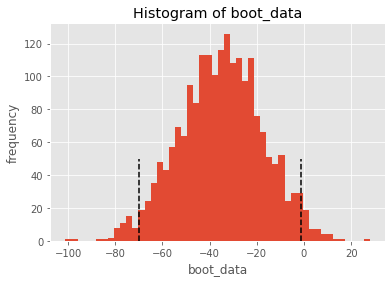

0.047126226784112886


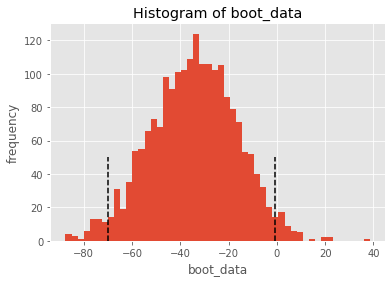

0.051855930811104574


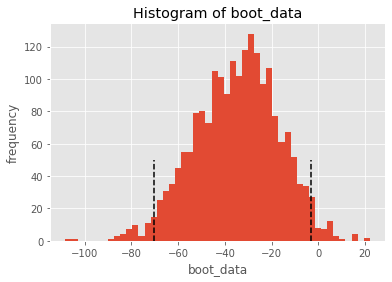

0.05006706066311063


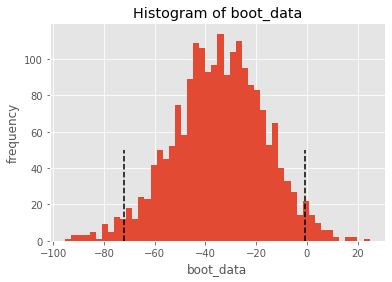

0.05501829667429209


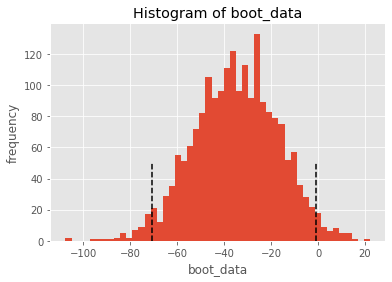

0.05247997582933775


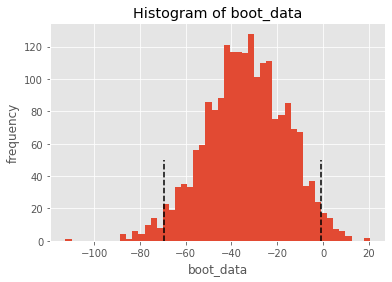

0.05603893487363094
mean = 0.05155950213784108
p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами


In [76]:
# "ios", "Sweden" 
df1 = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "ios" \
                                 and country == "Sweden" and sex == "male"').revenue,
                       df.query('group == "B" and platform == "ios" \
                                 and country == "Sweden" and sex == "male"').revenue)
    df1.append(it)
    print(it)
print(f'mean = {mean(df1)}')
if mean(df1) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

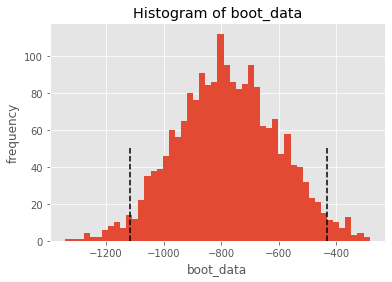

9.283383669184518e-06


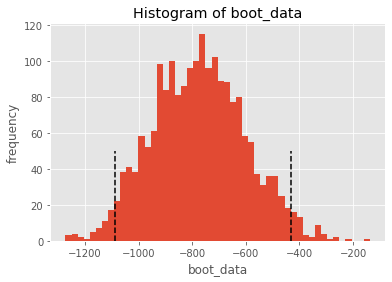

7.087958808890569e-06


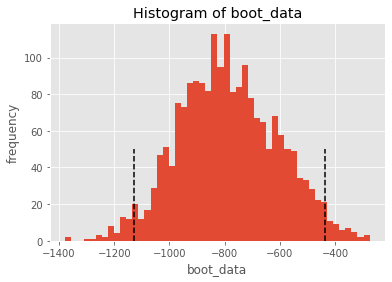

9.58162171447362e-06


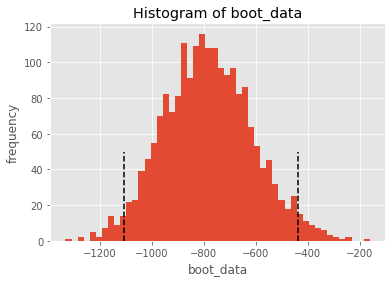

4.445740725281777e-06


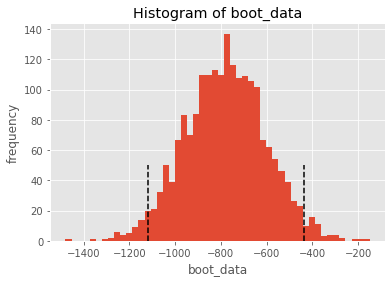

9.027394896186682e-06


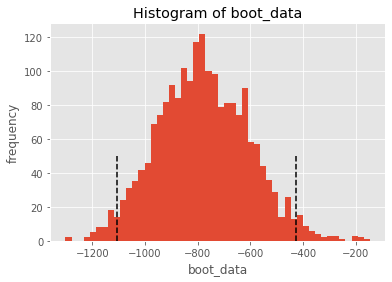

7.225160205894996e-06


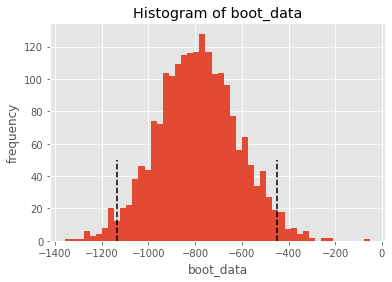

5.745169398369719e-06


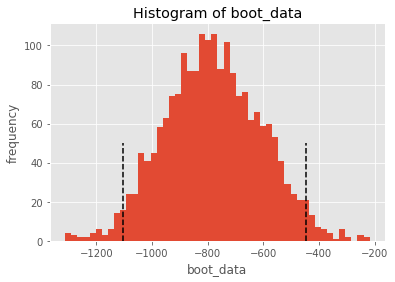

6.887931986972458e-06


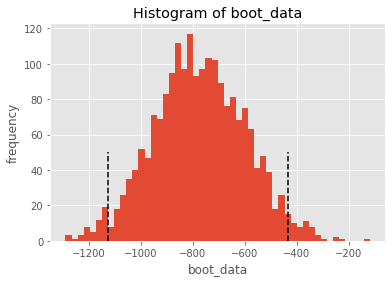

9.714924795681109e-06


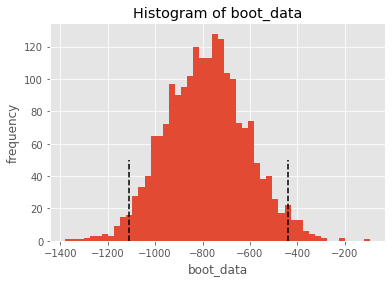

4.904626428148336e-06
mean = 7.390391262908378e-06
p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами


In [77]:
# revenue > 0, "ios", "Sweden" 
df1 = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "ios" \
                                 and country == "Sweden" and sex == "male" and revenue > 0').revenue,
                       df.query('group == "B" and platform == "ios" \
                                 and country == "Sweden" and sex == "male" and revenue > 0').revenue)
    df1.append(it)
    print(it)
print(f'mean = {mean(df1)}')
if mean(df1) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

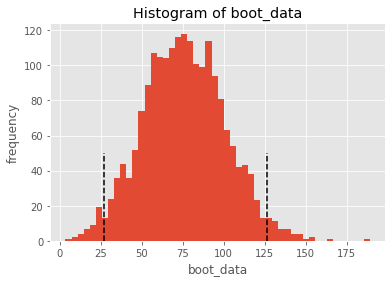

0.00232130404226595


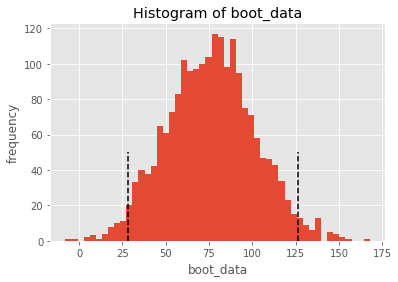

0.002565946064585116


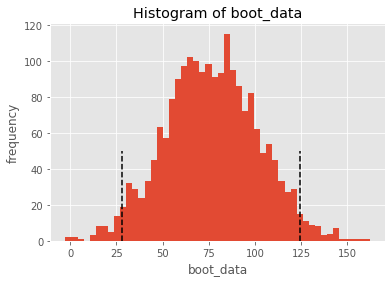

0.002243048439148631


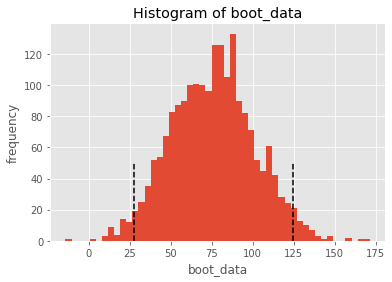

0.0026161910004604324


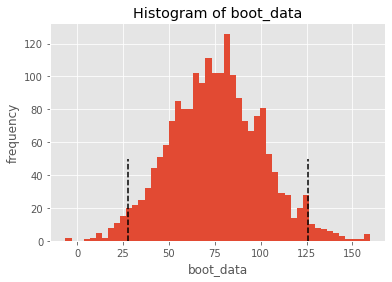

0.002382614838213943


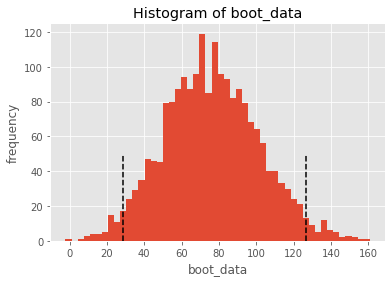

0.0026355812336303092


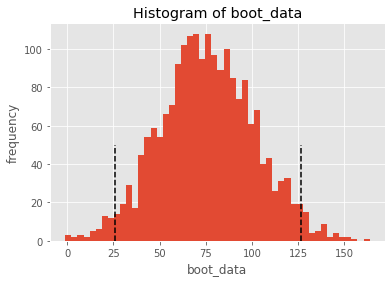

0.002798572387244704


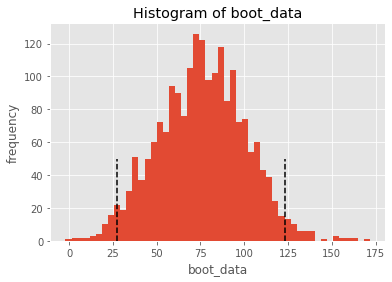

0.002237520153473472


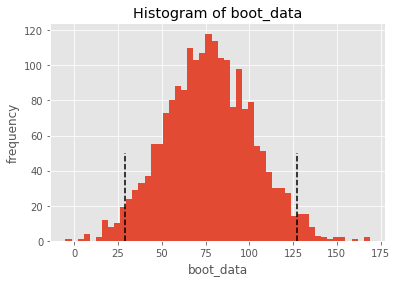

0.0021122635741180184


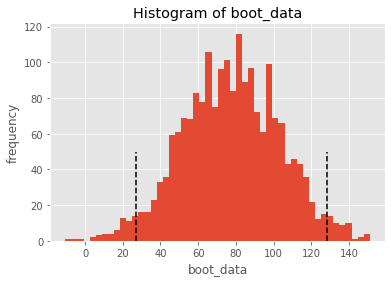

0.0025605157721984833
mean = 0.002447355750533906
p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами


In [78]:
# "android", "Sweden" 
df1 = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "android" \
                                 and country == "Sweden" and sex == "male"').revenue,
                       df.query('group == "B" and platform == "android" \
                                 and country == "Sweden" and sex == "male"').revenue)
    df1.append(it)
    print(it)
print(f'mean = {mean(df1)}')
if mean(df1) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

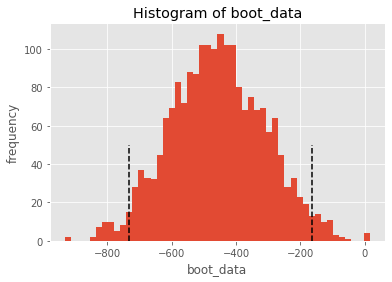

0.0019924617772586694


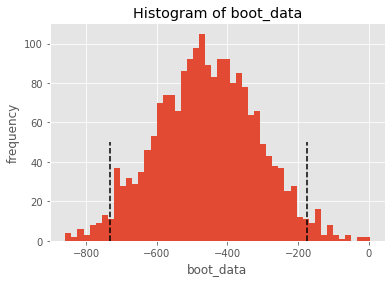

0.001338477454763905


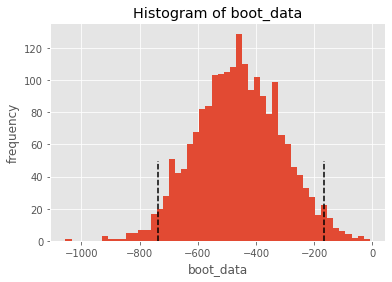

0.0017416551865019015


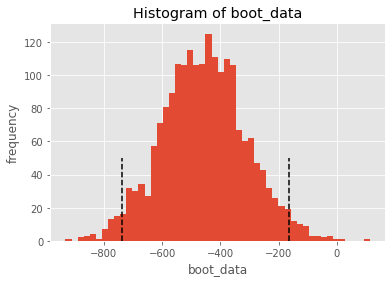

0.0016071626920675017


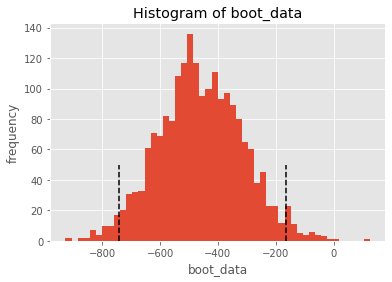

0.0016392351940206359


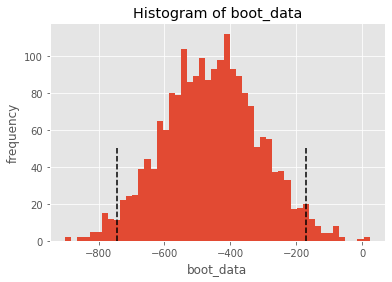

0.001585100538976022


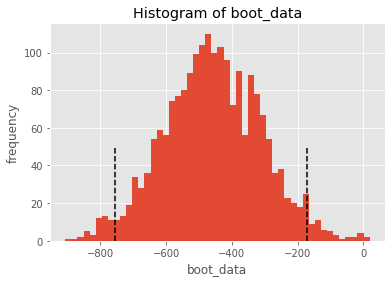

0.0018223392653005472


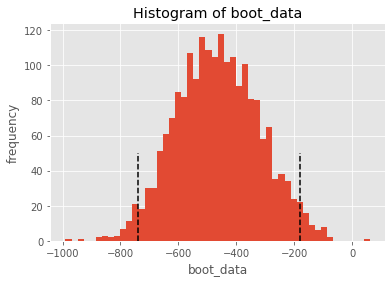

0.0012490186075931296


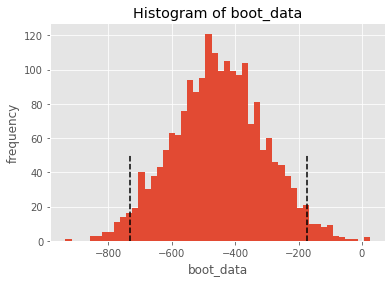

0.0016695814961705012


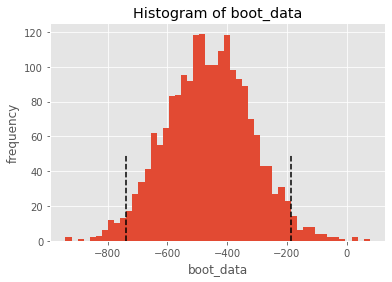

0.0012445361395892617
mean = 0.0015889568352242076
p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами


In [79]:
# revenue > 0, "android" , "Sweden" 
df1 = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "android" \
                                 and country == "Sweden" and sex == "female" and revenue > 0').revenue,
                       df.query('group == "B" and platform == "android" \
                                 and country == "Sweden" and sex == "female" and revenue > 0').revenue)
    df1.append(it)
    print(it)
print(f'mean = {mean(df1)}')
if mean(df1) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

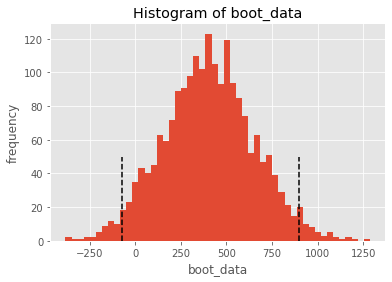

0.10116981693404285


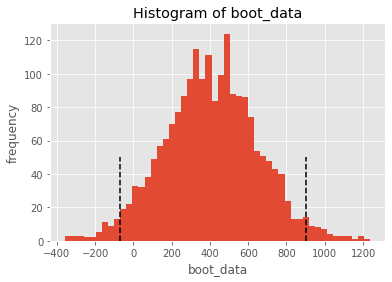

0.09694032566079448


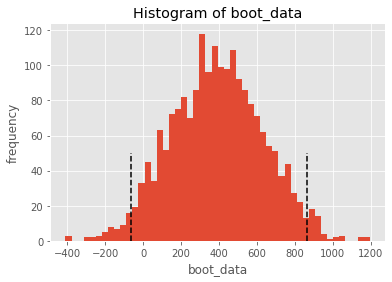

0.10542470813298373


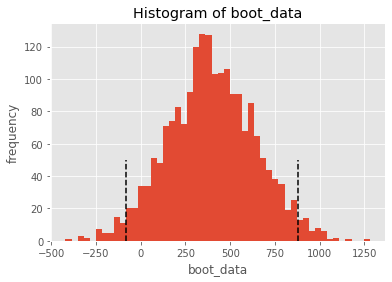

0.10235080953556779


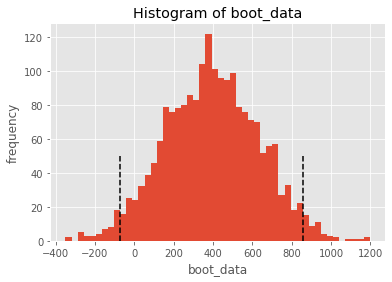

0.0964469630407639


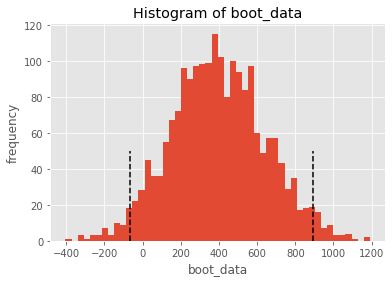

0.10491596888042552


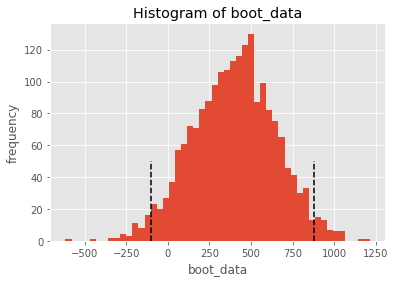

0.11213415889884867


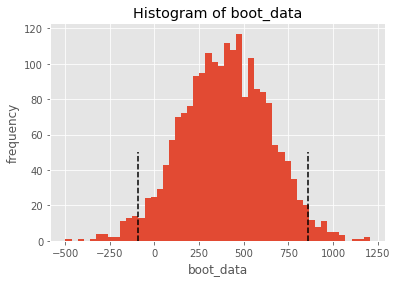

0.10349441570014792


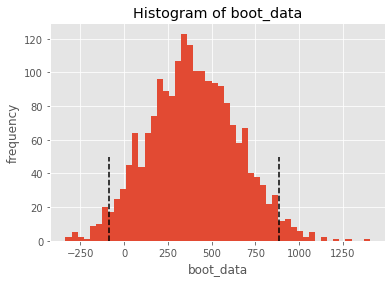

0.11771556394731356


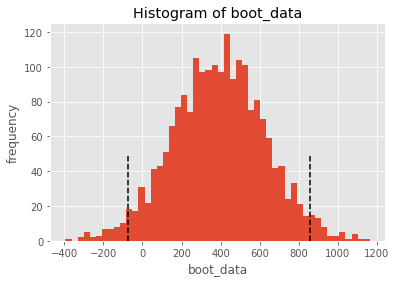

0.09656311627117768
mean = 0.10371558470020661
p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами


In [80]:
# revenue > 0, "android" , "Sweden" 
df1 = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "android" \
                                 and country == "Sweden" and sex == "male" and revenue > 0').revenue,
                       df.query('group == "B" and platform == "android" \
                                 and country == "Sweden" and sex == "male" and revenue > 0').revenue)
    df1.append(it)
    print(it)
print(f'mean = {mean(df1)}')
if mean(df1) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

 Мужчины из Швеции, пользующиеся платформой android стали меньше вкладывать в приложении. 

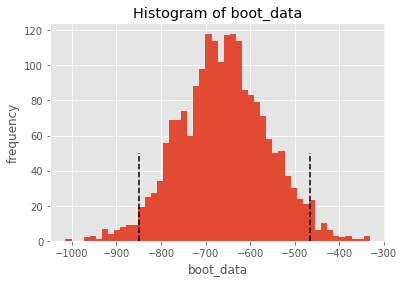

3.191645196492141e-11


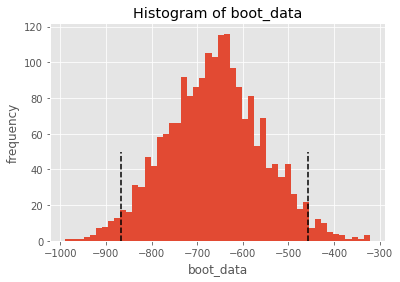

2.7876189064402056e-10


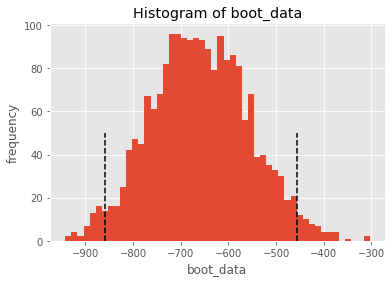

1.417305786566956e-10


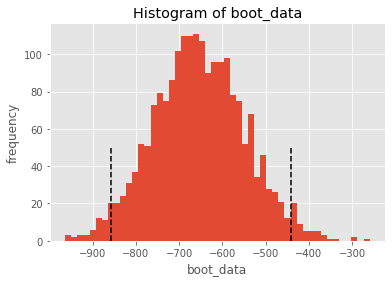

3.9024161305700133e-10


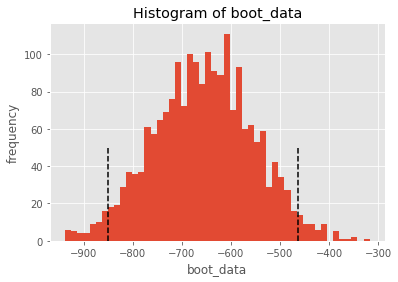

9.249823509166323e-11


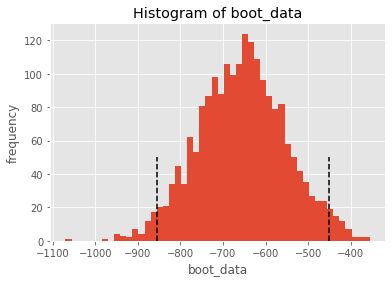

1.5220903521483305e-10


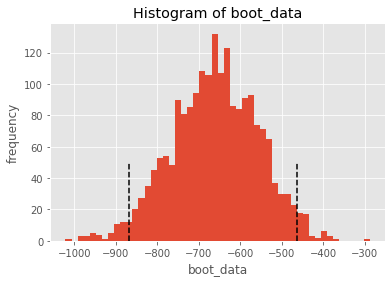

2.2023486537972389e-10


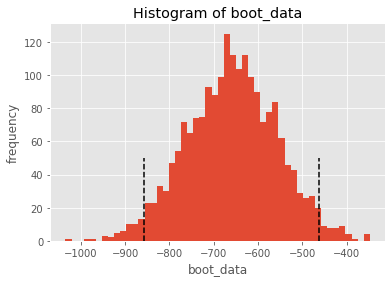

9.05675755679829e-11


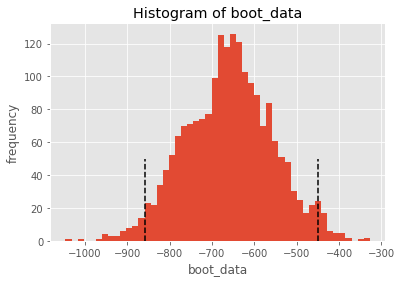

1.9507486207391707e-10


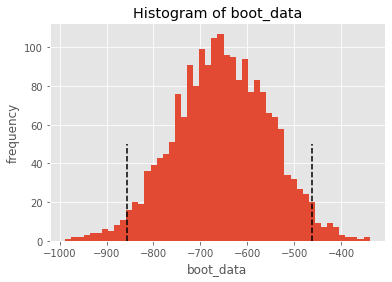

1.3303223115659827e-10
mean = 1.7262673388073572e-10
p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами


In [81]:
# revenue > 0, "android" , "Russia" 
df1 = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "android" \
                                 and country == "Russia" and sex == "male" and revenue > 0').revenue,
                       df.query('group == "B" and platform == "android" \
                                 and country == "Russia" and sex == "male" and revenue > 0').revenue)
    df1.append(it)
    print(it)
print(f'mean = {mean(df1)}')
if mean(df1) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

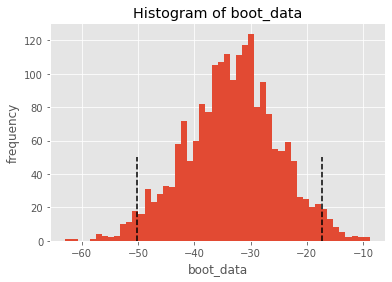

5.0057560436947107e-05


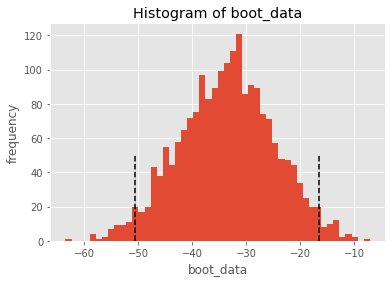

0.00011217326415766384


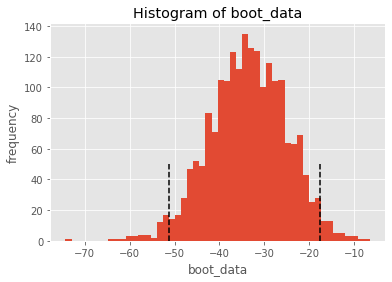

8.424885395074072e-05


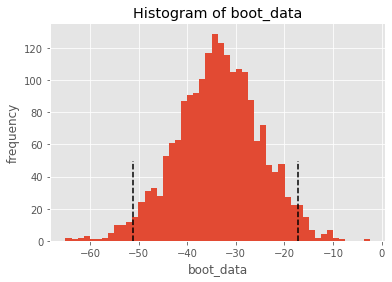

0.0001080741458386595


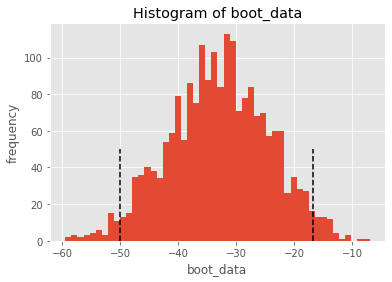

0.0001168625540967156


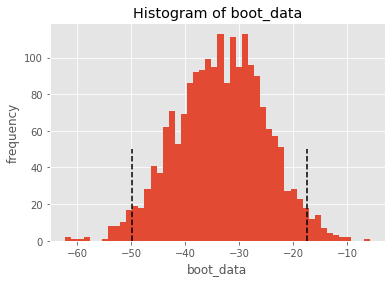

5.5862908667122104e-05


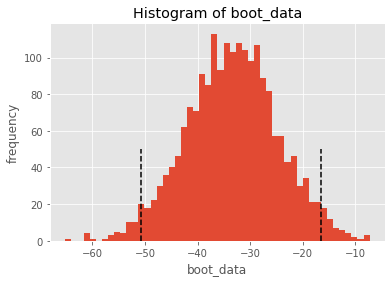

0.00011696925313706045


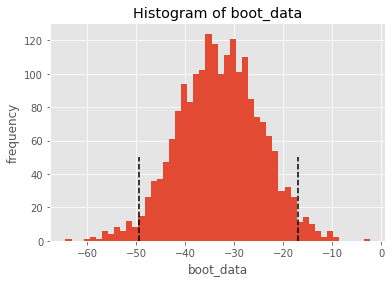

8.128447314422846e-05


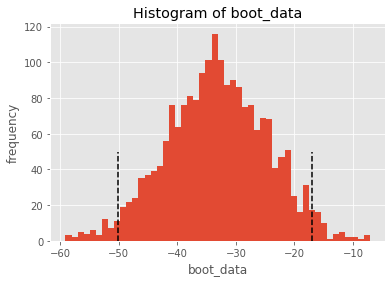

9.999649800787959e-05


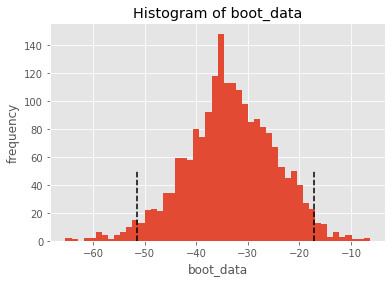

0.00011547972074346937
mean = 9.410092321804868e-05
p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами


In [82]:
# "android", "Russia" 
df1 = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "android" \
                                 and country == "Russia" and sex == "male"').revenue,
                       df.query('group == "B" and platform == "android" \
                                 and country == "Russia" and sex == "male"').revenue)
    df1.append(it)
    print(it)
print(f'mean = {mean(df1)}')
if mean(df1) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

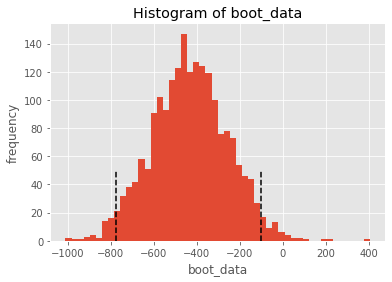

0.014345087526683125


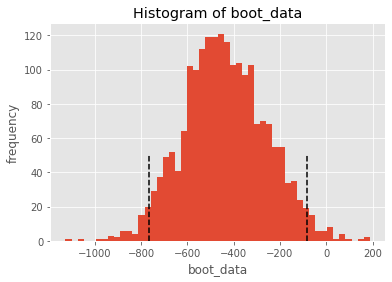

0.01446888958563328


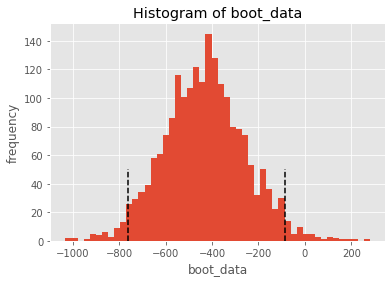

0.014426595413722937


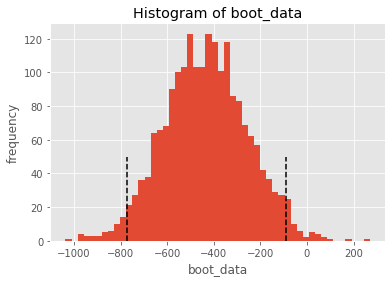

0.014245589186855522


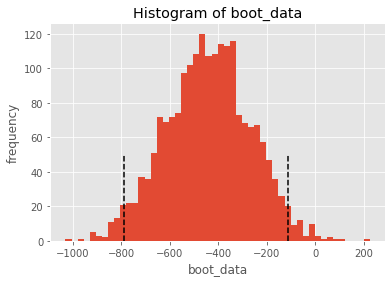

0.011598969785986814


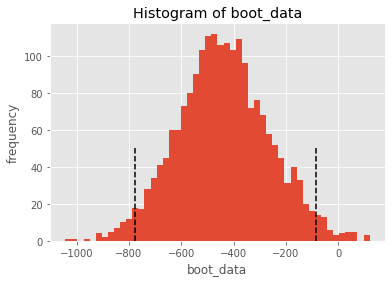

0.012149897340626431


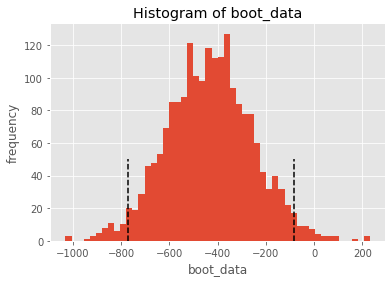

0.014607201845899044


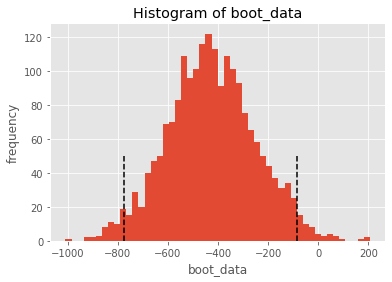

0.014866616324678505


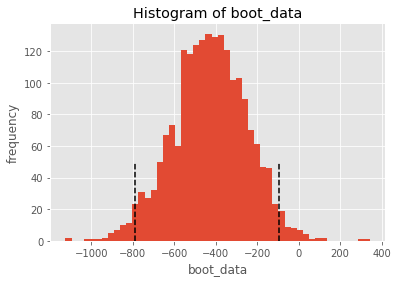

0.017242052135538026


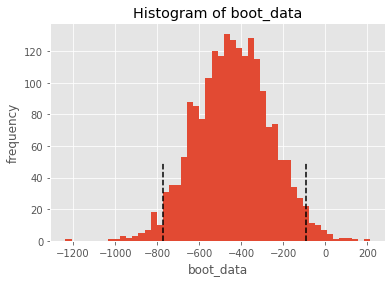

0.01364997204227711
mean = 0.01416008711879008
p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами


In [83]:
# revenue > 0, "ios", "Russia" 
df1 = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "ios" \
                                 and country == "Russia" and sex == "female" and revenue > 0').revenue,
                       df.query('group == "B" and platform == "ios" \
                                 and country == "Russia" and sex == "female" and revenue > 0').revenue)
    df1.append(it)
    print(it)
print(f'mean = {mean(df1)}')
if mean(df1) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

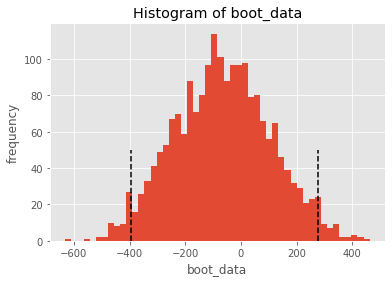

0.7010033220535756


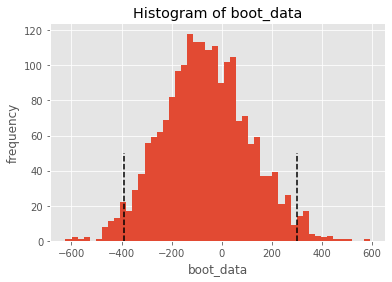

0.7179685602360375


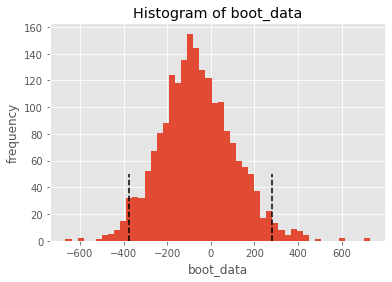

0.7117246248379014


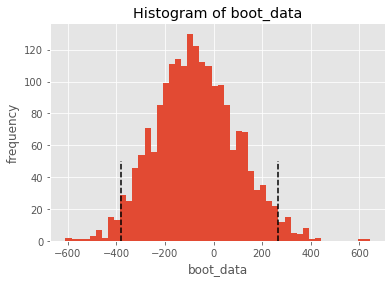

0.6691219244830553


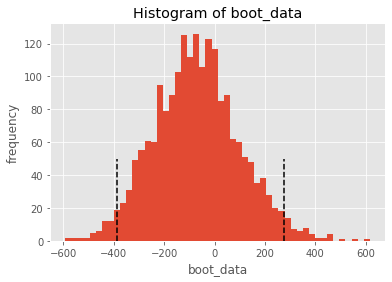

0.6799648478150018


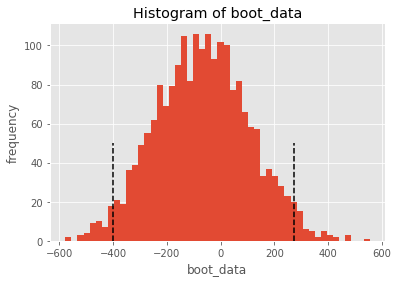

0.699612231218832


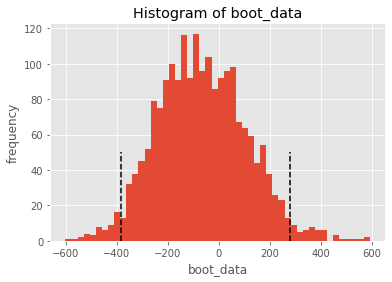

0.7046212106082939


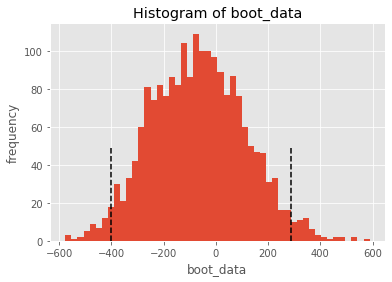

0.7084244430618096


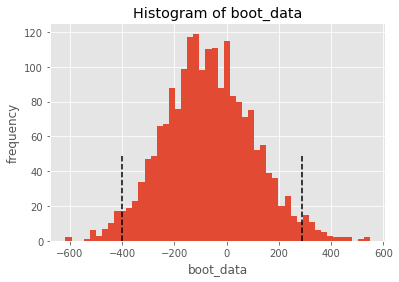

0.6869524883242789


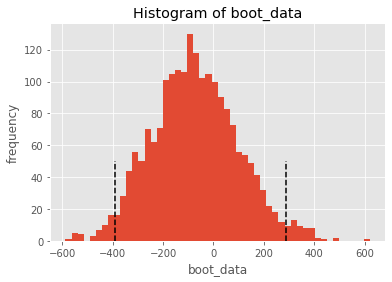

0.6714753404670711
mean = 0.6950868993105858
p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами


In [84]:
# revenue > 0, "ios", "Russia" 
df1 = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "ios" \
                                 and country == "Russia" and sex == "male" and revenue > 0').revenue,
                       df.query('group == "B" and platform == "ios" \
                                 and country == "Russia" and sex == "male" and revenue > 0').revenue)
    df1.append(it)
    print(it)
print(f'mean = {mean(df1)}')
if mean(df1) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

 Мужчины из России, пользующиеся платформой ios стали меньше вкладывать финансовых средств в приложение, в отличие от женщин на ios 

Данное исследование показало, что статзначимые различия имеются между контрольной и тестовой группами

### Выводы

А/В-тестирование выявило статистическую разницу между контрольной и тестовой группами, которая позволяет прийти к выводу, что можно выкатывать новую модель на остальных пользователей.
Пользователи из России и Швеции были проанализированы отдельно:
Мужчины из Швеции, пользующиеся платформой android стали меньше вкладывать денежных средств в приложениеб как и
мужчины из России, пользующиеся платформой ios стали меньше вкладывать средства в приложение

### 2. Дашборд


https://public.tableau.com/app/profile/.36022585/viz/dashboard_16569779863860/Dashboard1?publish=yes